# 📊 Analyse Rapide - Dataset CICIDS2017
**IDS Intelligent basé Deep Learning & LLM**

Ce notebook fournit une analyse **claire et concise** du dataset pour préparer l'entraînement du modèle.

In [1]:
# 1. IMPORTS & CHARGEMENT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Chargement
df = pd.read_csv('dataset/cicids2017_cleaned.csv')
print(f"✅ Dataset chargé: {df.shape[0]:,} samples × {df.shape[1]} colonnes\n")

✅ Dataset chargé: 2,520,751 samples × 53 colonnes



In [2]:
# 2. EXPLORATION RAPIDE
print("="*70)
print("📋 OVERVIEW DU DATASET")
print("="*70)

# Types de données
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\n• Colonnes numériques: {len(numeric_cols)}")
print(f"• Colonnes catégorielles: {len(categorical_cols)}")
print(f"• Valeurs manquantes: {df.isnull().sum().sum()}")
print(f"• Doublons: {df.duplicated().sum()}")

# Colonne cible
label_col = categorical_cols[-1] if categorical_cols else df.columns[-1]
print(f"\n🎯 Colonne cible: '{label_col}'")

# Distribution des classes
class_dist = df[label_col].value_counts()
print(f"\n📊 Classes:")
for cls, count in class_dist.items():
    pct = count/len(df)*100
    print(f"  {cls:15} : {count:10,} ({pct:5.1f}%)")

imbalance = class_dist.max() / class_dist.min()
print(f"\n⚠️  Ratio d'imbalance: {imbalance:.1f}:1")

📋 OVERVIEW DU DATASET

• Colonnes numériques: 52
• Colonnes catégorielles: 1
• Valeurs manquantes: 0
• Doublons: 161

🎯 Colonne cible: 'Attack Type'

📊 Classes:
  Normal Traffic  :  2,095,057 ( 83.1%)
  DoS             :    193,745 (  7.7%)
  DDoS            :    128,014 (  5.1%)
  Port Scanning   :     90,694 (  3.6%)
  Brute Force     :      9,150 (  0.4%)
  Web Attacks     :      2,143 (  0.1%)
  Bots            :      1,948 (  0.1%)

⚠️  Ratio d'imbalance: 1075.5:1


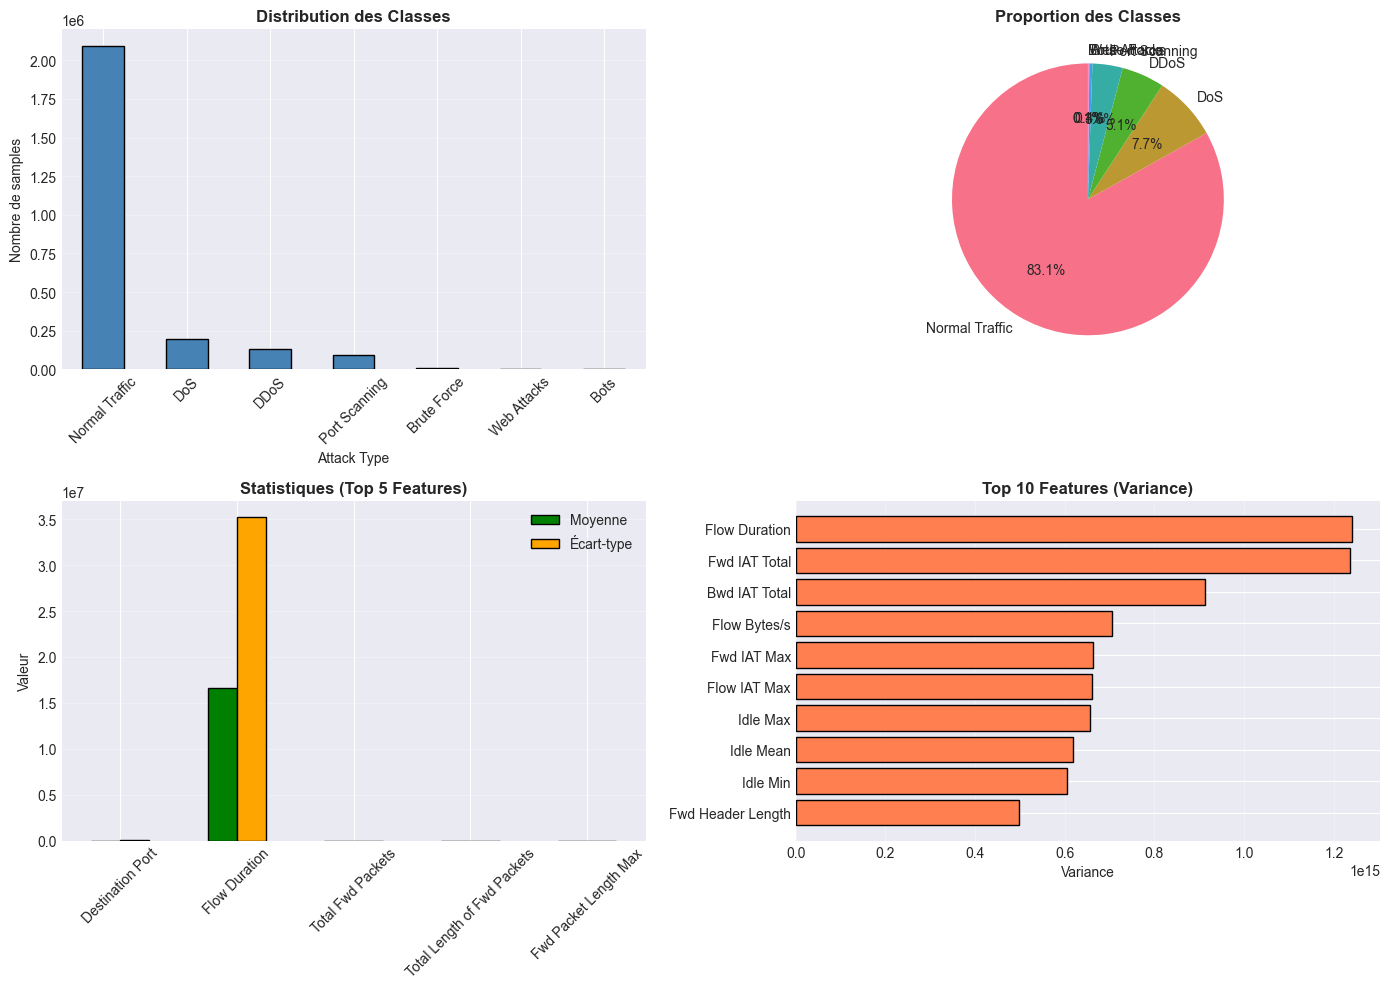


✅ Visualisations sauvegardées


In [3]:
# 3. VISUALISATIONS CLÉS
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 3.1 Distribution des classes
class_dist.plot(kind='bar', ax=axes[0,0], color='steelblue', edgecolor='black')
axes[0,0].set_title('Distribution des Classes', fontweight='bold')
axes[0,0].set_ylabel('Nombre de samples')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3, axis='y')

# 3.2 Pie chart
axes[0,1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Proportion des Classes', fontweight='bold')

# 3.3 Statistiques par colonne
stats_sample = df[numeric_cols[:5]].describe().loc[['mean', 'std']].T
stats_sample.plot(kind='bar', ax=axes[1,0], color=['green', 'orange'], edgecolor='black')
axes[1,0].set_title('Statistiques (Top 5 Features)', fontweight='bold')
axes[1,0].set_ylabel('Valeur')
axes[1,0].legend(['Moyenne', 'Écart-type'])
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3, axis='y')

# 3.4 Variance des features
variance = np.var(df[numeric_cols], axis=0)
top_var_idx = np.argsort(variance)[-10:]
axes[1,1].barh(range(10), variance[top_var_idx], color='coral', edgecolor='black')
axes[1,1].set_yticks(range(10))
axes[1,1].set_yticklabels([numeric_cols[i] for i in top_var_idx])
axes[1,1].set_title('Top 10 Features (Variance)', fontweight='bold')
axes[1,1].set_xlabel('Variance')
axes[1,1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('analysis_overview.png', dpi=100, bbox_inches='tight')
plt.show()
print("\n✅ Visualisations sauvegardées")


🔗 CORRÉLATION & FEATURE SELECTION

Features redondantes (corr > 0.95): 12
  À supprimer: ['Fwd IAT Max', 'Idle Min', 'Packet Length Std', 'Fwd Packets/s', 'Idle Max']...

Top 5 Features par Variance:
  Flow Duration             : 1241251148569051.2500
  Fwd IAT Total             : 1236580812797503.5000
  Bwd IAT Total             : 913690538991273.1250
  Flow Bytes/s              : 706022428697379.2500
  Fwd IAT Max               : 663902017656907.2500


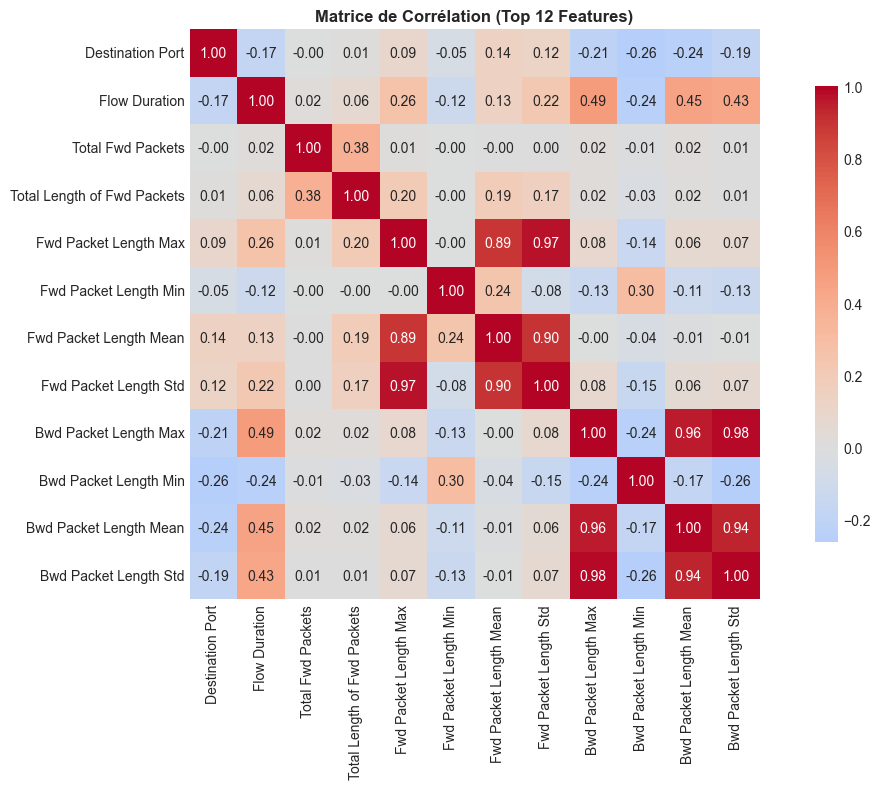


✅ Matrice de corrélation sauvegardée


In [4]:
# 4. CORRÉLATION ET FEATURES
print("\n" + "="*70)
print("🔗 CORRÉLATION & FEATURE SELECTION")
print("="*70)

# Corrélation (sur échantillon)
sample_df = df[numeric_cols].sample(min(10000, len(df)), random_state=42)
corr_matrix = sample_df.corr()

# Features redondantes (corr > 0.95)
redundant = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            redundant.add(corr_matrix.columns[j])

print(f"\nFeatures redondantes (corr > 0.95): {len(redundant)}")
if redundant:
    print(f"  À supprimer: {list(redundant)[:5]}...")

# Top features par variance
var_df = pd.DataFrame({'Feature': numeric_cols, 'Variance': variance}).sort_values('Variance', ascending=False)
print(f"\nTop 5 Features par Variance:")
for idx, row in var_df.head(5).iterrows():
    print(f"  {row['Feature']:25} : {row['Variance']:.4f}")

# Heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df[numeric_cols[:12]].corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={"shrink": 0.8})
ax.set_title('Matrice de Corrélation (Top 12 Features)', fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=100, bbox_inches='tight')
plt.show()
print("\n✅ Matrice de corrélation sauvegardée")


⚙️  PRÉPARATION POUR LE MODÈLE

Classes encodées:
  0 → Bots
  1 → Brute Force
  2 → DDoS
  3 → DoS
  4 → Normal Traffic
  5 → Port Scanning
  6 → Web Attacks

Normalisation StandardScaler:
  Mean: 0.000000
  Std:  1.000000

PCA (2 composantes):
  Variance expliquée: 38.64%


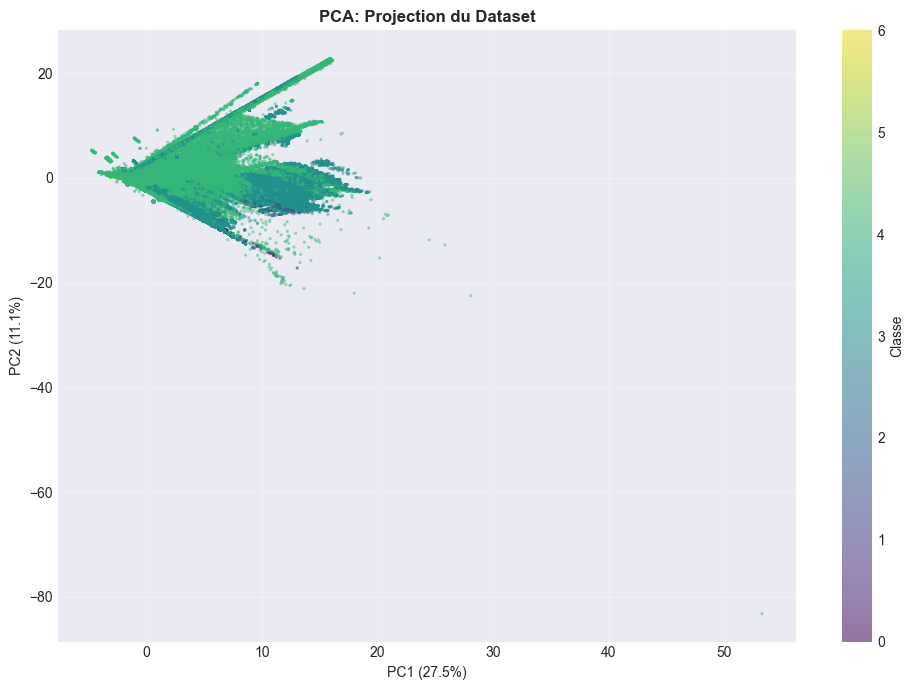

✅ Projection PCA sauvegardée


In [5]:
# 5. PRÉTRAITEMENT & NORMALISATION
print("\n" + "="*70)
print("⚙️  PRÉPARATION POUR LE MODÈLE")
print("="*70)

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df[label_col])
print(f"\nClasses encodées:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {i} → {cls}")

# Normalisation
X = df[numeric_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nNormalisation StandardScaler:")
print(f"  Mean: {X_scaled.mean():.6f}")
print(f"  Std:  {X_scaled.std():.6f}")

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_var = sum(pca.explained_variance_ratio_)
print(f"\nPCA (2 composantes):")
print(f"  Variance expliquée: {pca_var:.2%}")

# Visualisation PCA
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', 
                     alpha=0.5, s=5, edgecolors='none')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA: Projection du Dataset', fontweight='bold')
cbar = plt.colorbar(scatter)
cbar.set_label('Classe')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_projection.png', dpi=100, bbox_inches='tight')
plt.show()
print("✅ Projection PCA sauvegardée")

In [6]:
# 6. RECOMMANDATIONS POUR LE MODÈLE
print("\n" + "="*70)
print("🎯 RECOMMANDATIONS POUR LE MODÈLE DEEP LEARNING")
print("="*70)

# Analyser l'imbalance
if imbalance > 100:
    balance_strategy = "class_weight='balanced' + SMOTE"
    loss_fn = "CrossEntropyLoss + Focal Loss"
elif imbalance > 10:
    balance_strategy = "class_weight='balanced'"
    loss_fn = "CrossEntropyLoss"
else:
    balance_strategy = "Pas nécessaire"
    loss_fn = "CrossEntropyLoss standard"

print(f"\n1️⃣  GESTION DU DÉSÉQUILIBRE")
print(f"   Ratio: {imbalance:.1f}:1")
print(f"   Stratégie: {balance_strategy}")
print(f"   Loss: {loss_fn}")

print(f"\n2️⃣  ARCHITECTURE RECOMMANDÉE")
print(f"   Input: {len(numeric_cols)} features")
print(f"   Output: {len(class_dist)} classes")
print(f"   \n   Option 1 (LSTM):")
print(f"      LSTM(128) → Dense(64) → Dense({len(class_dist)}) + Softmax")
print(f"   \n   Option 2 (Transformer):")
print(f"      MultiHeadAttention → Dense(256) → Dense({len(class_dist)}) + Softmax")
print(f"   \n   Option 3 (Autoencoder):")
print(f"      Encoder(128→64→32) → Decoder(32→64→128) → Classify")

print(f"\n3️⃣  HYPERPARAMÈTRES")
print(f"   • Batch Size: 32")
print(f"   • Learning Rate: 0.001 (Adam)")
print(f"   • Epochs: 50-100")
print(f"   • Dropout: 0.2-0.3")
print(f"   • Validation Split: 0.2")

print(f"\n4️⃣  MÉTRIQUES D'ÉVALUATION")
if imbalance > 10:
    print(f"   • Precision-Recall Curve (⭐ principale)")
    print(f"   • F1-Score par classe")
    print(f"   • Confusion Matrix")
    print(f"   • ROC-AUC")
else:
    print(f"   • Accuracy")
    print(f"   • ROC-AUC")
    print(f"   • F1-Score")
    print(f"   • Confusion Matrix")


🎯 RECOMMANDATIONS POUR LE MODÈLE DEEP LEARNING

1️⃣  GESTION DU DÉSÉQUILIBRE
   Ratio: 1075.5:1
   Stratégie: class_weight='balanced' + SMOTE
   Loss: CrossEntropyLoss + Focal Loss

2️⃣  ARCHITECTURE RECOMMANDÉE
   Input: 52 features
   Output: 7 classes
   
   Option 1 (LSTM):
      LSTM(128) → Dense(64) → Dense(7) + Softmax
   
   Option 2 (Transformer):
      MultiHeadAttention → Dense(256) → Dense(7) + Softmax
   
   Option 3 (Autoencoder):
      Encoder(128→64→32) → Decoder(32→64→128) → Classify

3️⃣  HYPERPARAMÈTRES
   • Batch Size: 32
   • Learning Rate: 0.001 (Adam)
   • Epochs: 50-100
   • Dropout: 0.2-0.3
   • Validation Split: 0.2

4️⃣  MÉTRIQUES D'ÉVALUATION
   • Precision-Recall Curve (⭐ principale)
   • F1-Score par classe
   • Confusion Matrix
   • ROC-AUC
